<a href="https://colab.research.google.com/github/johnmichaelt/cmsc_191_paper_neural_network/blob/main/Obesity_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas
import tensorflow
import seaborn
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# FILE READING AND FORMATTING
dataframe = pandas.read_csv("/content/ObesityDataSet_raw_and_data_sinthetic.csv", header=0)
dataframe = dataframe.dropna()

# TRANSFORM CLASS INPUT (TRANSPORTATION) INTO CLASSIFICATION COLUMNS
dummy_transportation = pandas.get_dummies(dataframe['MTRANS'],  drop_first=True)
dataframe = pandas.concat([dataframe, dummy_transportation], axis=1)
dataframe.drop('MTRANS', axis=1, inplace=True)
dataframe = dataframe[[c for c in dataframe if c not in ['NObeyesdad']] + [c for c in ['NObeyesdad'] if c in dataframe]]
dataframe = dataframe.sort_values(['NObeyesdad'])




In [3]:
# DATAFRAME -> NUMPY.NDARRAY
dataset = dataframe.values
group_segments = []
group_label = []
group_index = []
group_count = 0
string_segment = dataset[0][19]

# MULTICLASS COUNT & MULTICLASS LABEL COLLECTION
for item_index in range(len(dataset)):
  group_count += 1
  if dataset[item_index][19] == string_segment:
    continue
  else:
    group_label.append(string_segment)
    string_segment = dataset[item_index][19]
    group_segments.append(group_count)
    group_index.append(item_index)
    group_count = 0
group_index.append(len(dataset) - 1)
group_label.append(string_segment)
group_segments.append(group_count)

# IDENTIFICATION OF TRAINING-VALIDATION-TESTING (TVT) SET SIZES PER CLASS
training_count = [int(x) for x in (list(np.around([count * 0.6 for count in group_segments])))]
validation_count = [int(x) for x in (list(np.around([count * 0.2 for count in group_segments])))]
testing_count = [group_segments[x] - training_count[x] - validation_count[x] for x in range(len(group_segments))]

# INITIALIZE SETS (COLLECTIVE)
training_set = np.empty([1,20])
validation_set = np.empty([1,20])
testing_set = np.empty([1,20])




In [4]:
# DATASET SEPARATION PER CLASS FOR STRATIFIED SAMPLING
insufficient_group = dataset[0:273, :]
normal_group = dataset[273:560, :]
obesity_i_group = dataset[560:911, :]
obesity_ii_group = dataset[911:1208, :]
obesity_iii_group = dataset[1208:1532, :]
overweight_i_group = dataset[1532:1822, :]
overweight_ii_group = dataset[1822:2111, :]

# SHUFFLE CLASS, GET TVT SCALING PER CLASS, BUILD COLLECTIVE SET
def shuffle_list(list_group, category):
  for item in range(5):
    np.random.shuffle(list_group)
  validation_testing_boundary = training_count[category] + validation_count[category]
  testing_boundary = validation_testing_boundary + testing_count[category]
  training_list = list_group[0:training_count[category]]
  validation_list = list_group[training_count[category]:validation_testing_boundary]
  testing_list = list_group[validation_testing_boundary:testing_boundary]
  global training_set
  global validation_set
  global testing_set
  training_set = np.concatenate((training_set, training_list), axis=0)
  validation_set = np.concatenate((validation_set, validation_list), axis=0)
  testing_set = np.concatenate((testing_set, testing_list), axis=0)

shuffle_list(insufficient_group, 0)
shuffle_list(normal_group, 1)
shuffle_list(obesity_i_group, 2)
shuffle_list(obesity_ii_group, 3)
shuffle_list(obesity_iii_group, 4)
shuffle_list(overweight_i_group, 5)
shuffle_list(overweight_ii_group, 6)

# REMOVE GARBAGE VALUE FROM INITIALIZATION
training_set = np.delete(training_set, 0, 0)
validation_set = np.delete(validation_set, 0, 0)
testing_set = np.delete(testing_set, 0, 0)




In [5]:
# ASSEMBLE SEPARATED SETS FOR TRANSFORMATION
entire_dataset = np.concatenate((training_set, validation_set, testing_set), axis=0)

# NON-QUANTITATIVE DATA TRANSFORMATION TO QUANTITATIVE FORMAT (EXCEPT OBESITY CLASSIFICATION COLUMN)
for item in entire_dataset:
  for dataIndex in range(len(item)):
    if (dataIndex == 0 and item[dataIndex] == "Female") or item[dataIndex] == "yes" or ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Sometimes"):
      item[dataIndex] = 1
    elif ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Frequently"):
      item[dataIndex] = 2
    elif ((dataIndex == 8 or dataIndex == 14) and item[dataIndex] == "Always"):
      item[dataIndex] = 3
    elif item[dataIndex] == "no" or (dataIndex == 0 and item[dataIndex] == "Male"):
      item[dataIndex] = 0

training_count_total = sum(training_count)
validation_count_total = sum(validation_count)
testing_count_total = sum(testing_count)

# SPLIT ASSEMBLED MODIFIED SET TO TVT SETS
Train_set_random = entire_dataset[0:training_count_total,:]
Validation_set_random = entire_dataset[training_count_total:training_count_total + validation_count_total, :]
Test_set_random = entire_dataset[training_count_total + validation_count_total:, :]

# SHUFFLE TVT SETS
np.random.shuffle(Train_set_random)
np.random.shuffle(Validation_set_random)
np.random.shuffle(Test_set_random)

# X AND Y DATA ISOLATION FOR EACH SET IN TVT SETS
X_train = Train_set_random[:,0:19].astype('float32')
Y_train = Train_set_random[:,19]
X_validation = Validation_set_random[:,0:19].astype('float32')
Y_validation = Validation_set_random[:,19]
X_test = Test_set_random[:, 0:19].astype('float32')
Y_test = Test_set_random[:,19]

# DATA SCALING FOR EASIER DATA MANAGEMENT
scaler = StandardScaler()
# scaler = Normalizer()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# Y DATA COLUMN TRANSFORMATION TO CATEGORICAL MANAGEABLE DATA
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
encoded_Y_validation = encoder.transform(Y_validation)
encoded_Y_test = encoder.transform(Y_test)

dummy_Y_train = np_utils.to_categorical(encoded_Y_train)
dummy_Y_validation = np_utils.to_categorical(encoded_Y_validation)
dummy_Y_test = np_utils.to_categorical(encoded_Y_test)




In [27]:
# MODEL CONSTRUCTION
BATCH_SIZE = 20
EPOCHS = 25

stop_model_learning = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=0, mode="min", patience=10, restore_best_weights=True)

def main_model():
  model = Sequential()
  initializer = tensorflow.keras.initializers.RandomNormal(mean=0., stddev=1.)
  model.add(Dense(19, input_dim=19, activation='relu'))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(11, activation='relu'))
  model.add(Dense(7, activation='softmax', bias_initializer=initializer))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    CategoricalAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    AUC(name = 'aucroc', curve = 'ROC')
  ])
  return model

# INITIALIZATION OF MODEL
initial_model = main_model()
initial_model.save_weights('start_weights.model')

# FINAL MODEL TRAINING
obesity_model = main_model()
obesity_model.load_weights('start_weights.model')
records = obesity_model.fit(X_train, dummy_Y_train, verbose=1, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_validation, dummy_Y_validation))




Epoch 1/25
64/64 [==============================] - 2s 11ms/step - loss: 2.0426 - accuracy: 0.1754 - precision: 0.0417 - recall: 7.8989e-04 - aucroc: 0.5455 - val_loss: 1.8926 - val_accuracy: 0.2133 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_aucroc: 0.6035
Epoch 2/25
64/64 [==============================] - 0s 4ms/step - loss: 1.7986 - accuracy: 0.2923 - precision: 0.1250 - recall: 0.0016 - aucroc: 0.6742 - val_loss: 1.6786 - val_accuracy: 0.4028 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_aucroc: 0.7489
Epoch 3/25
64/64 [==============================] - 0s 3ms/step - loss: 1.5976 - accuracy: 0.4250 - precision: 0.2857 - recall: 0.0032 - aucroc: 0.7981 - val_loss: 1.4920 - val_accuracy: 0.4621 - val_precision: 1.0000 - val_recall: 0.0142 - val_aucroc: 0.8389
Epoch 4/25
64/64 [==============================] - 0s 3ms/step - loss: 1.4206 - accuracy: 0.5205 - precision: 0.8154 - recall: 0.0419 - aucroc: 0.8573 - val_loss: 1.3286 - val_accuracy: 0.5047 - val

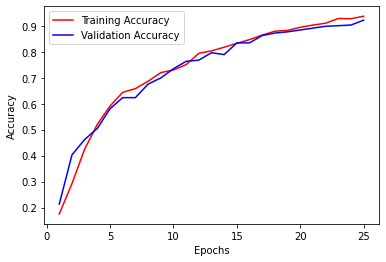

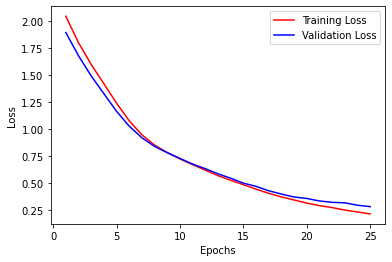

In [28]:
# TRAINING STATISTICS/GRAPH: ACCURACY
print("\n")
accuracy_train = records.history['accuracy']
accuracy_validation = records.history['val_accuracy']
plt.plot(range(1,EPOCHS + 1), accuracy_train, 'r', label="Training Accuracy")
plt.plot(range(1,EPOCHS + 1), accuracy_validation, 'b', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("\n")

# TRAINING STATISTICS/GRAPH: LOSS
loss_train = records.history['loss']
loss_validation = records.history['val_loss']
plt.plot(range(1,EPOCHS + 1), loss_train, 'r', label="Training Loss")
plt.plot(range(1,EPOCHS + 1), loss_validation, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
print("\n")

# MODEL PREDICTION FOR A GIVEN SET
# WITH MODEL STATISTICS
def predict_model(X_variable, Y_variable):
  model_prediction_test = obesity_model.predict(X_variable)
  model_statistics = obesity_model.evaluate(X_variable, Y_variable, batch_size = BATCH_SIZE)
  for item in range(len(model_statistics)):
    print(obesity_model.metrics_names[item], ": ", model_statistics[item])
  model_matrix = confusion_matrix(Y_variable.argmax(1), model_prediction_test.argmax(1))
  print(classification_report(Y_variable.argmax(1), model_prediction_test.argmax(1), digits = 3))
  show_confusion_matrix_diagram(model_matrix)

# CONFUSION MATRIX VISUALIZATION OF A GIVEN SET
def show_confusion_matrix_diagram(confusion_matrix):
  frame_matrix = pandas.DataFrame(confusion_matrix, index = group_label, columns = group_label)
  plt.figure(figsize = (8,5))
  seaborn.heatmap(frame_matrix, annot=True, fmt="d", cmap="YlGnBu")
  plt.xlabel('Predicted Level')
  plt.ylabel('Actual Level')




64/64 [==============================] - 0s 2ms/step - loss: 0.2050 - accuracy: 0.9423 - precision: 0.9528 - recall: 0.9250 - aucroc: 0.9976
loss :  0.20495827496051788
accuracy :  0.9423380494117737
precision :  0.9528071880340576
recall :  0.9249604940414429
aucroc :  0.9975591897964478
              precision    recall  f1-score   support

           0      0.915     0.988     0.950       164
           1      0.904     0.830     0.866       171
           2      0.981     0.991     0.986       211
           3      0.989     0.994     0.992       178
           4      1.000     0.995     0.997       194
           5      0.846     0.880     0.863       175
           6      0.945     0.902     0.923       173

    accuracy                          0.942      1266
   macro avg      0.940     0.940     0.940      1266
weighted avg      0.943     0.942     0.942      1266



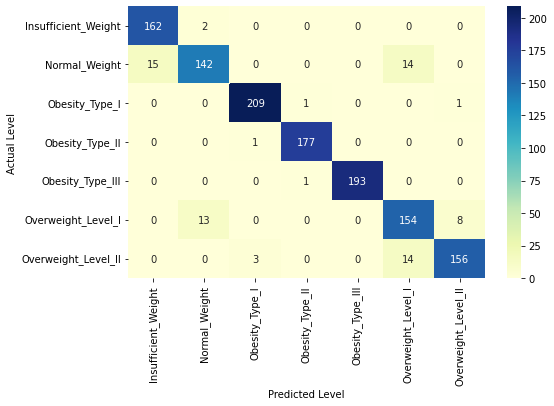

In [29]:
predict_model(X_train, dummy_Y_train)

22/22 [==============================] - 0s 2ms/step - loss: 0.3683 - accuracy: 0.8794 - precision: 0.8949 - recall: 0.8652 - aucroc: 0.9845
loss :  0.36826661229133606
accuracy :  0.8794326186180115
precision :  0.8948655128479004
recall :  0.8652482032775879
aucroc :  0.98445063829422
              precision    recall  f1-score   support

           0      0.904     0.887     0.895        53
           1      0.759     0.695     0.726        59
           2      0.919     0.971     0.944        70
           3      0.983     0.950     0.966        60
           4      1.000     1.000     1.000        65
           5      0.738     0.776     0.756        58
           6      0.831     0.845     0.838        58

    accuracy                          0.879       423
   macro avg      0.876     0.875     0.875       423
weighted avg      0.879     0.879     0.879       423



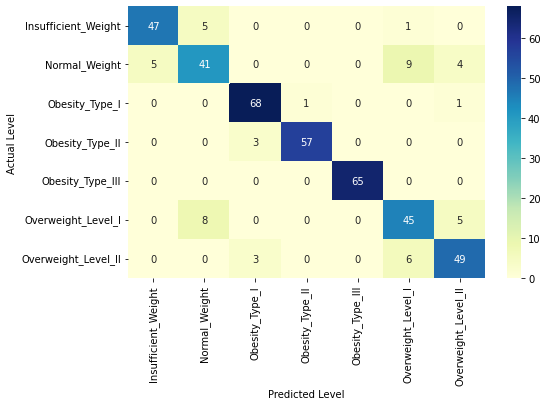

In [30]:
predict_model(X_test, dummy_Y_test)

In [31]:
for weight_set in obesity_model.get_weights():
  print(weight_set)
  print("\n\n")

[[-0.16965061  0.25697592 -0.43455562  0.00397237 -0.6056172   0.3615681
  -0.09283122 -0.1305037  -0.12699999  0.04954709 -0.61444753  0.2122162
   0.0955343  -0.27172336 -0.56672114 -0.11103297 -0.04893195  0.4609012
  -0.01209195]
 [ 0.20687757  0.20372543  0.3582659  -0.3856877   0.35026726 -0.20263176
   0.12609275 -0.02024375 -0.78385705  0.00254884  0.21043746  0.6537601
   0.15151478  0.05022993  0.47571424  0.07187477 -0.4042247   0.2767493
   0.14470196]
 [-0.01504099 -0.05366391 -0.44294238  0.1674732   0.03029679  0.18186921
   0.52903086 -0.14920342 -0.34879187  0.17173165  0.11473624 -0.21258125
  -0.40486744 -0.07466065  0.34477967  0.32911977  0.11267994 -0.02628242
   0.02303399]
 [ 0.28828493 -0.25937986  0.63786983 -0.88790226  0.453428    0.05316905
  -1.2470357  -0.46099356  0.17532168 -0.18113406 -0.45127854 -0.42036125
   0.81015277  1.2470006  -0.6824812  -0.9289999  -0.18625815  0.5393462
  -1.3083838 ]
 [-0.27625254 -0.16720666  0.00300534 -0.21528256  0.14617